# Выпускная квалификационная работа

## Разработка программного обеспечения для выявления заболеваемости растений по изображениям

__Выполнила__: студентка группы БВТ1901 Катанаева И.В.

__Научный руководитель:__ Потапченко Т.Д.

In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import random

from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Изначально полученный датасет

Первоначальный датасет был получен объединением следующих датасетов в один:
- [AppleLeaf9](https://github.com/JasonYangCode/AppleLeaf9)
- [PlantVillage-Dataset](https://github.com/spMohanty/PlantVillage-Dataset)

In [3]:
dataset_path = 'AppleDiseases1'
disease_classes = os.listdir(dataset_path)
disease_classes

['black_rot',
 'blotch',
 'healthy',
 'mosaic',
 'powdery_mildew',
 'rust',
 'scab',
 'spot_alternaria',
 'spot_brown',
 'spot_frogeye',
 'spot_grey']

In [4]:
def printDatasetFileCount(path):
    print('Dataset filecount:')
    for disease_class in os.listdir(path):
        count = len(os.listdir(os.path.join(path, disease_class)))
        print('-', disease_class, ':', count)

In [5]:
printDatasetFileCount(dataset_path)

Dataset filecount:
- black_rot : 621
- blotch : 111
- healthy : 1645
- mosaic : 371
- powdery_mildew : 1184
- rust : 275
- scab : 630
- spot_alternaria : 417
- spot_brown : 411
- spot_frogeye : 3181
- spot_grey : 339


## Преобразование и аугментация полученного датасета

__Цель__: сделать так, чтобы в каждом классе было минимум 1000 изображений

In [4]:
preprocess_path = 'AppleDiseases2'

In [6]:
# Копируем изначальный датасет в новую директорию для дальнейшей работы
shutil.copytree(dataset_path, preprocess_path, dirs_exist_ok=True)
printDatasetFileCount(preprocess_path)

Dataset filecount:
- black_rot : 621
- blotch : 111
- healthy : 1645
- mosaic : 371
- powdery_mildew : 1184
- rust : 275
- scab : 630
- spot_alternaria : 417
- spot_brown : 411
- spot_frogeye : 3181
- spot_grey : 339


In [40]:
ROTATE_45 = 7
ROTATE_135 = 8

# Функция для агументации датасета
def imageAugmentation(path, fileformat, transforms):
    fileformat = "." + fileformat
    path = os.path.join(preprocess_path, path)
    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        with Image.open(filepath) as img:
            img.load()
        for idx, transform in enumerate(transforms):
            newfilepath = filepath.replace(fileformat, f"_{idx}" + fileformat)
            if not os.path.isfile(newfilepath):
                if transform == ROTATE_45:
                    converted_img = img.rotate(45, expand=False)
                elif transform == ROTATE_135:
                    converted_img = img.rotate(135, expand=False)
                else:
                    converted_img = img.transpose(transform)
                converted_img.save(newfilepath)

In [33]:
imageAugmentation('black_rot', 'JPG', [Image.FLIP_LEFT_RIGHT])
imageAugmentation('blotch', 'jpeg', [Image.FLIP_TOP_BOTTOM, Image.FLIP_LEFT_RIGHT, Image.ROTATE_90,
    Image.ROTATE_270, Image.TRANSPOSE, Image.TRANSVERSE, Image.ROTATE_180, ROTATE_45, ROTATE_135])
imageAugmentation('mosaic', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('rust', 'JPG', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE, Image.TRANSPOSE])
imageAugmentation('scab', 'JPG', [Image.FLIP_LEFT_RIGHT])
imageAugmentation('spot_alternaria', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('spot_brown', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('spot_grey', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])

In [42]:
printDatasetFileCount(preprocess_path)

Dataset filecount:
- black_rot : 1242
- blotch : 1110
- healthy : 1645
- mosaic : 1484
- powdery_mildew : 1184
- rust : 1375
- scab : 1260
- spot_alternaria : 1668
- spot_brown : 1644
- spot_frogeye : 1550
- spot_grey : 1356


## Создание torch.utils.data.Dataset и torch.utils.data.DataLoader

In [5]:
dataset_path = preprocess_path

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
apple_diseases_dataset = torchvision.datasets.ImageFolder(dataset_path, transform=img_transform)
train_size = int(len(apple_diseases_dataset)*0.8)
test_size  = len(apple_diseases_dataset) - train_size
train_diseases, test_diseases = torch.utils.data.random_split(apple_diseases_dataset, [train_size, test_size])

In [7]:
train_diseases_dataloader = DataLoader(train_diseases, batch_size=16, shuffle=True, pin_memory=True)
test_diseases_dataloader = DataLoader(test_diseases, batch_size=16, pin_memory=True)

## Отображение случайных объектов из датасета

In [8]:
class ImageTransform:
    def __call__(self, x):
        out = x.reshape(3, 128, 128).permute(1, 2, 0)
        out = out - out.min()
        out = out / out.max()
        return out

In [20]:
def showFromDataset(dataset, classes, shapeX, shapeY, transforms=None):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom=-0.0, right=1.1)
    for x in range(shapeX):
        for y in range(shapeY):
            example, label = random.choice(dataset)
            if transforms:
                example = transforms(example)
            plt.subplot(shapeX, shapeY, x * shapeY + y + 1)
            plt.imshow(example)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"Apple disease: {classes[label]}")

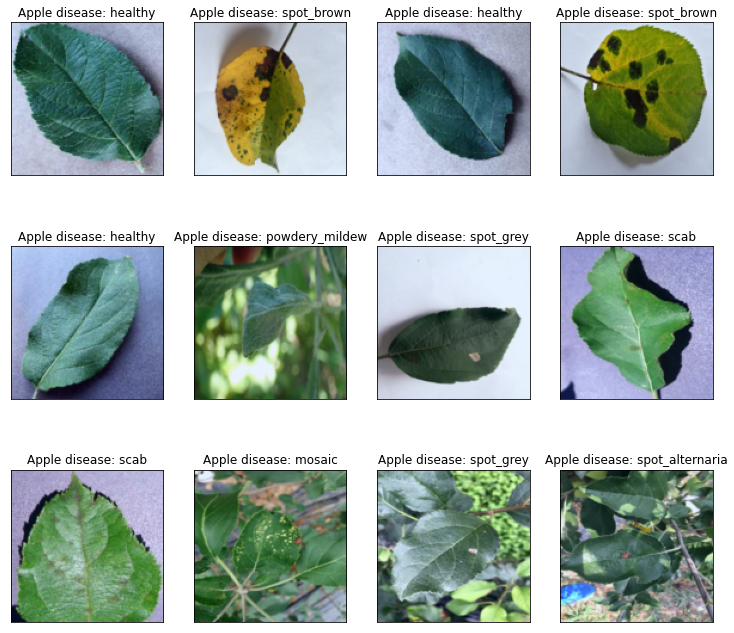

In [24]:
showFromDataset(test_diseases, disease_classes, 3, 4, transforms=ImageTransform())

## Функции для обучения модели

In [9]:
def calculate_accuracy(y_pred, y_true):
    """Multiclass problem accuracy"""
    y_pred = torch.argmax(y_pred, dim=1)
    return (torch.sum(y_pred == y_true) / len(y_true)).item()

In [10]:
def train(train_loader, model, loss, optimizer, device):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        curr_loss = loss(y_pred, y_batch)
        curr_loss.backward()
        optimizer.step()
        train_loss += curr_loss
        train_acc += calculate_accuracy(y_pred, y_batch)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    return train_loss, train_acc

In [11]:
def test(test_loader, model, loss, device):
    test_loss = 0.0
    test_acc = 0.0
    with torch.inference_mode():
        model.eval()
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            curr_loss = loss(y_pred, y_batch)
            test_loss += curr_loss
            test_acc += calculate_accuracy(y_pred, y_batch)
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    return test_loss, test_acc

In [12]:
def fit_model(train_loader, test_loader, model, loss, optimizer, epochs, device='cpu'):
    train_loss_history = []
    test_loss_history = []
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train(train_loader, model, loss, optimizer, device)
        test_loss, test_acc = test(test_loader, model, loss, device)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | ", end='')
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")
    return train_loss_history, test_loss_history

## Графики

In [13]:
def plotLossModel(history_train, history_loss):
    history_train = torch.Tensor(history_train).cpu().numpy()
    history_loss = torch.Tensor(history_loss).cpu().numpy()
    n_epochs = len(history_train)
    with torch.no_grad():
        plt.figure(figsize=(12, 6))
        plt.plot(range(n_epochs), history_train, color='green', label='Train loss')
        plt.plot(range(n_epochs), history_loss, color='red', label='Test loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

In [14]:
def makeConfusionMatrix(loader, model, labels, device='cpu'):
    with torch.inference_mode():
        test_predictions = []
        test_grs = []
        for x, y in loader:
            x = x.to(device)
            preds = model.forward(x)
            test_predictions += list(torch.argmax(preds, dim=1).cpu())
            test_grs += list(y)

    plt.figure(figsize=(12, 9))
    sns.heatmap(metrics.confusion_matrix(test_grs, test_predictions),
                xticklabels=labels, yticklabels=labels, cmap="viridis", annot=True)

In [15]:
def checkModelPlot(dataset, classes, model, shapeX, shapeY, device='cpu', transforms=None):
    model.eval()
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom=-0.0, right=1.1)
    for x in range(shapeX):
        for y in range(shapeY):
            example, label = random.choice(dataset)
            example_cpu = example.unsqueeze(0)
            example_device = example_cpu.to(device)
            with torch.inference_mode():
                prediction = torch.argmax(model(example_device)).cpu()
            plt.subplot(shapeX, shapeY, x * shapeY + y + 1)
            if transforms:
                example_cpu = transforms(example_cpu)
            plt.imshow(example_cpu)
            plt.title(f"True: {classes[label]}\nModel: {classes[prediction]}")

## Создание и обучение модели

### VGG16 as base

In [12]:
class AppleDiseaseVggModel(nn.Module):
    def __init__(self, out_features):
        super(AppleDiseaseVggModel, self).__init__()
        # заморозка
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).requires_grad_(False)
        for param in model.features.parameters():
            param.require_grad = False
        # изменяем последний слой
        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1] 
        features.extend([nn.Linear(num_features, out_features)]) 
        model.classifier = nn.Sequential(*features)
        self.model = model
    
    def forward(self, data):
        return self.model(data)

In [13]:
model = AppleDiseaseVggModel(len(disease_classes))
model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 5

In [14]:
history_train, history_loss = fit_model(train_diseases_dataloader, test_diseases_dataloader,
                                        model, loss, optimizer, n_epochs, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.056 | Train acc: 0.668 | Test loss: 0.659 | Test acc: 0.828
Epoch: 1 | Train loss: 0.603 | Train acc: 0.809 | Test loss: 0.508 | Test acc: 0.857
Epoch: 2 | Train loss: 0.499 | Train acc: 0.838 | Test loss: 0.438 | Test acc: 0.869
Epoch: 3 | Train loss: 0.451 | Train acc: 0.847 | Test loss: 0.405 | Test acc: 0.874
Epoch: 4 | Train loss: 0.422 | Train acc: 0.853 | Test loss: 0.376 | Test acc: 0.876


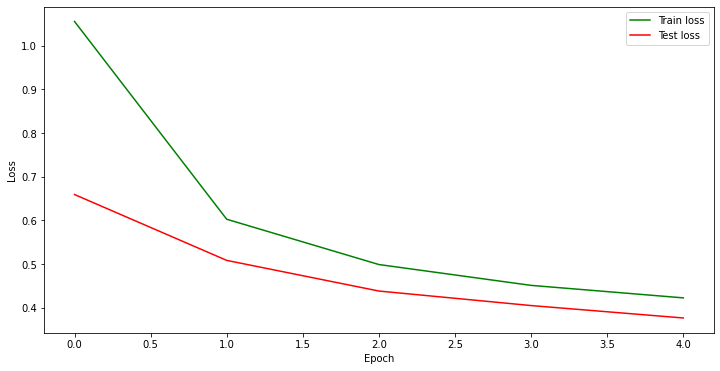

In [17]:
plotLossModel(history_train, history_loss)

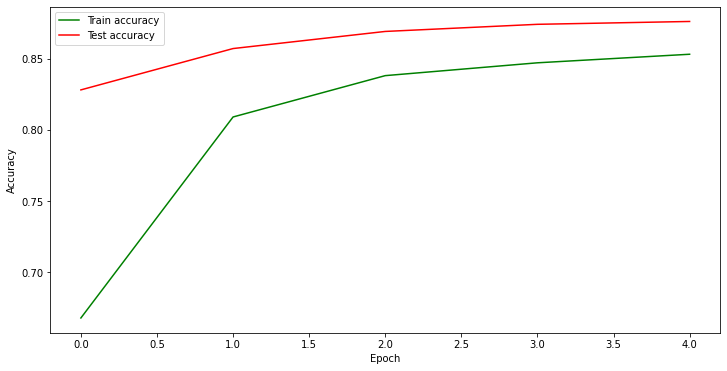

In [18]:
trainc_acc = [0.668, 0.809, 0.838, 0.847, 0.853]
test_acc   = [0.828, 0.857, 0.869, 0.874, 0.876]
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), trainc_acc, color='green', label='Train accuracy')
plt.plot(range(n_epochs), test_acc, color='red', label='Test accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### DenseNet121 as base

In [16]:
class AppleDiseaseModel(nn.Module):
    def __init__(self, out_features):
        super(AppleDiseaseModel, self).__init__()
        self.model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        # Классификатор
        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, out_features),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, data):
        return self.model(data)

In [13]:
model = AppleDiseaseModel(len(disease_classes))
model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 15

In [14]:
h_train, h_loss = fit_model(train_diseases_dataloader, test_diseases_dataloader, model, loss, optimizer, n_epochs, device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.555 | Train acc: 0.859 | Test loss: 0.102 | Test acc: 0.974
Epoch: 1 | Train loss: 0.151 | Train acc: 0.965 | Test loss: 0.071 | Test acc: 0.980
Epoch: 2 | Train loss: 0.086 | Train acc: 0.980 | Test loss: 0.055 | Test acc: 0.985
Epoch: 3 | Train loss: 0.061 | Train acc: 0.985 | Test loss: 0.060 | Test acc: 0.981
Epoch: 4 | Train loss: 0.049 | Train acc: 0.990 | Test loss: 0.043 | Test acc: 0.987
Epoch: 5 | Train loss: 0.048 | Train acc: 0.987 | Test loss: 0.052 | Test acc: 0.984
Epoch: 6 | Train loss: 0.035 | Train acc: 0.990 | Test loss: 0.043 | Test acc: 0.985
Epoch: 7 | Train loss: 0.032 | Train acc: 0.991 | Test loss: 0.062 | Test acc: 0.982
Epoch: 8 | Train loss: 0.034 | Train acc: 0.991 | Test loss: 0.040 | Test acc: 0.988
Epoch: 9 | Train loss: 0.024 | Train acc: 0.994 | Test loss: 0.067 | Test acc: 0.981
Epoch: 10 | Train loss: 0.033 | Train acc: 0.990 | Test loss: 0.045 | Test acc: 0.986
Epoch: 11 | Train loss: 0.022 | Train acc: 0.994 | Test loss: 0.

In [15]:
torch.save(model.state_dict(), 'AppleDiseaseModel2.pth')

### Функция потерь

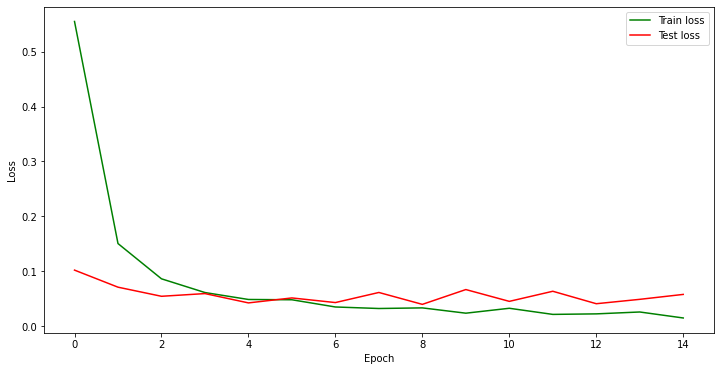

In [17]:
plotLossModel(h_train, h_loss)

### Точность модели

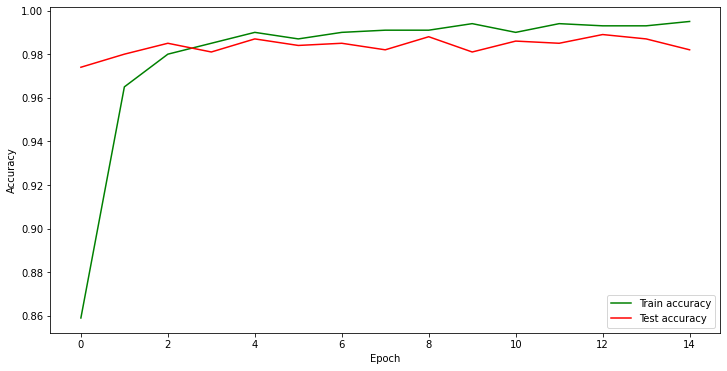

In [41]:
train_acc = [ 0.859, 0.965, 0.980, 0.985, 0.990, 0.987, 0.990, 0.991, 0.991, 0.994, 0.990, 0.994, 0.993, 0.993, 0.995 ]
test_acc  = [ 0.974, 0.980, 0.985, 0.981, 0.987, 0.984, 0.985, 0.982, 0.988, 0.981, 0.986, 0.985, 0.989, 0.987, 0.982 ]
n_epochs  = len(train_acc)

plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), train_acc, color='green', label='Train accuracy')
plt.plot(range(n_epochs), test_acc, color='red', label='Test accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [17]:
# Загрузка модели из файла
model = AppleDiseaseModel(len(disease_classes))
model.load_state_dict(torch.load('AppleDiseaseModel2.pth'))
model.to(device)

AppleDiseaseModelv2(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

### Матрица ошибок (confusion matrix)

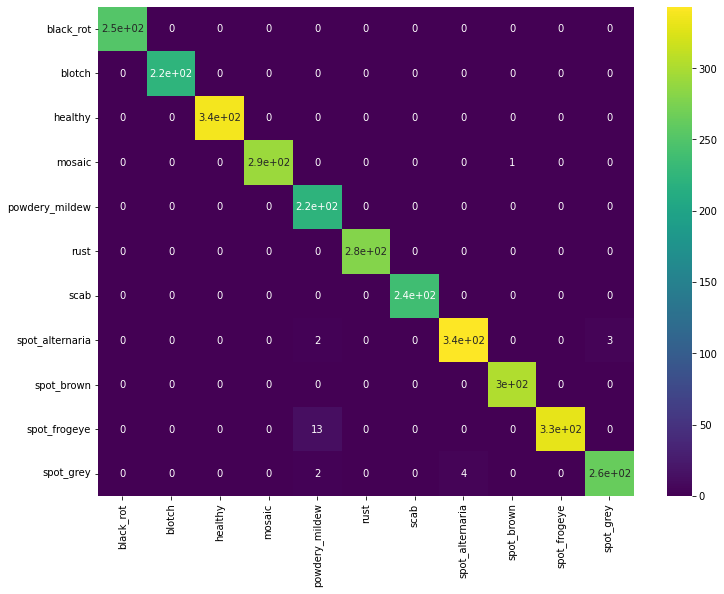

In [56]:
# Матрица ошибок
makeConfusionMatrix(test_diseases_dataloader, model, disease_classes, device)

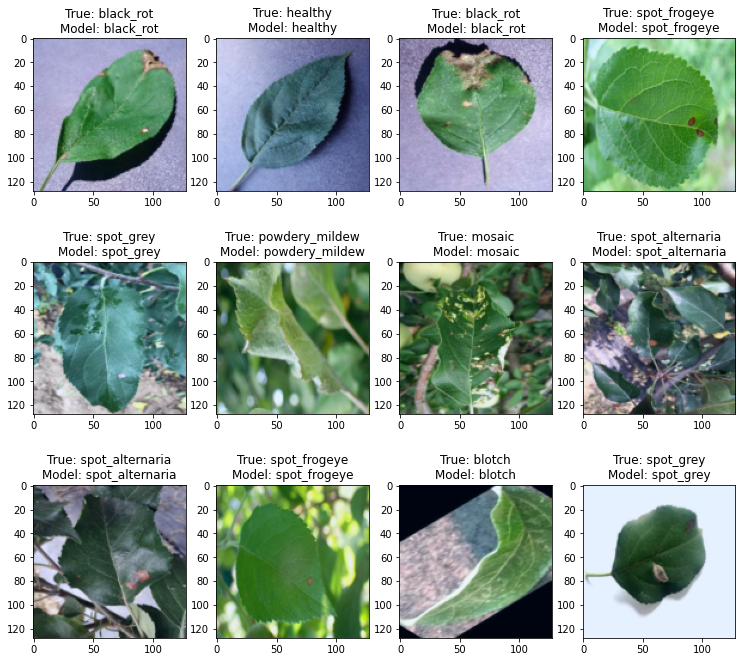

In [52]:
checkModelPlot(test_diseases, disease_classes, model, 3, 4, device, transforms=ImageTransform())

In [39]:
def plotRocPrecisionRecall(loader, model, classes, device='cpu'):
    # Изображение графика
    fig, axs = plt.subplots(2, 1)
    fig.set_figwidth(15)
    fig.set_figheight(16)
    colors = ['black', 'silver', 'gold', 'darkgreen',
              'deepskyblue', 'blue', 'red', 'darkorange',
              'crimson', 'magenta', 'green']
    
    n_classes = len(classes)
    with torch.inference_mode():
        test_predictions = []
        test_grs = []
        for x, y in loader:
            x = x.to(device)
            preds = model.forward(x)
            test_predictions += list(torch.argmax(preds, dim=1).cpu())
            test_grs += list(y)
    
    test_grs = torch.Tensor(test_grs)
    test_predictions = torch.Tensor(test_predictions)
    classes, count = test_grs.unique(return_counts=True)
    
    # Вычисление и отображение метрик на графики
    for class_ in classes:
        class_ = int(class_)
        class_name = disease_classes[class_]
        color = colors[class_]
        test = (test_grs == class_).numpy()
        predict = (test_predictions == class_).numpy()
        # ROC-кривая
        fpr, tpr, _ = roc_curve(test, predict)
        roc_auc = auc(fpr, tpr)
        axs[0].plot(fpr, tpr, label=f"ROC-curve (area is {roc_auc:.2f}) for {class_name}", color=color)
        # Precision-Recall-кривая
        pr, re, _ = precision_recall_curve(test, predict)
        axs[1].plot(re, pr, label=f"Precision-recall-curve for {class_name}", color=color)

    # Настройки первого графика
    axs[0].plot([0, 1], [0, 1], color="green", linestyle='--')
    axs[0].set_xlabel("False positive rate")
    axs[0].set_ylabel("True positive rate")
    axs[0].legend()
    axs[0].set_title("ROC Curve")

    # Настройки второго графика
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].legend()
    axs[1].set_title("Precision Recall Curve")
    plt.show()

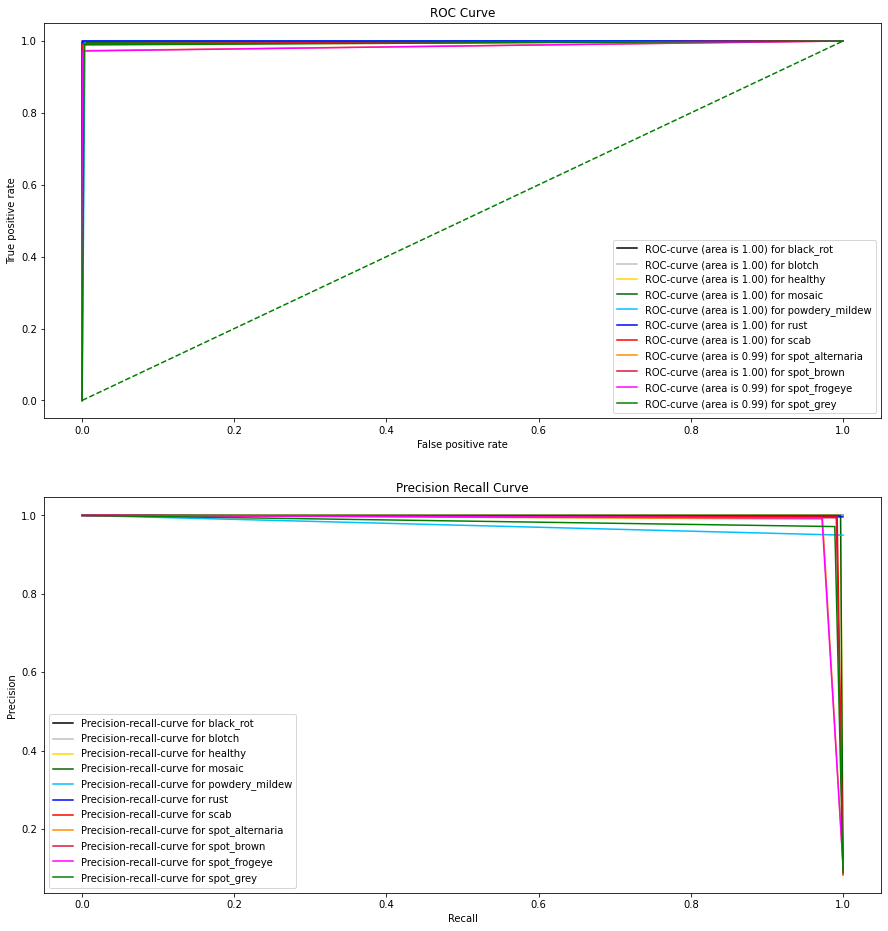

In [40]:
plotRocPrecisionRecall(test_diseases_dataloader, model, disease_classes, device)

In [20]:
test_grs = torch.Tensor(test_grs)
test_predictions = torch.Tensor(test_predictions)
classes, count = test_grs.unique(return_counts=True)

[1. 1.] [1. 0.]
[0.06862113 1.         1.        ] [1.         0.99530516 0.        ]
[1. 1.] [1. 0.]
[1. 1.] [1. 0.]
[0.94117647 1.        ] [1. 0.]
[0.99628253 1.        ] [1. 0.]
[0.08344072 1.         1.        ] [1.       0.996139 0.      ]
[0.10760309 0.98787879 1.        ] [1.        0.9760479 0.       ]
[0.10889175 1.         1.        ] [1.         0.99408284 0.        ]
[0.10470361 0.99681529 1.        ] [1.         0.96307692 0.        ]
[0.08923969 0.9751773  1.        ] [1.         0.99277978 0.        ]


Text(0.5, 1.0, 'Precision Recall Curve')

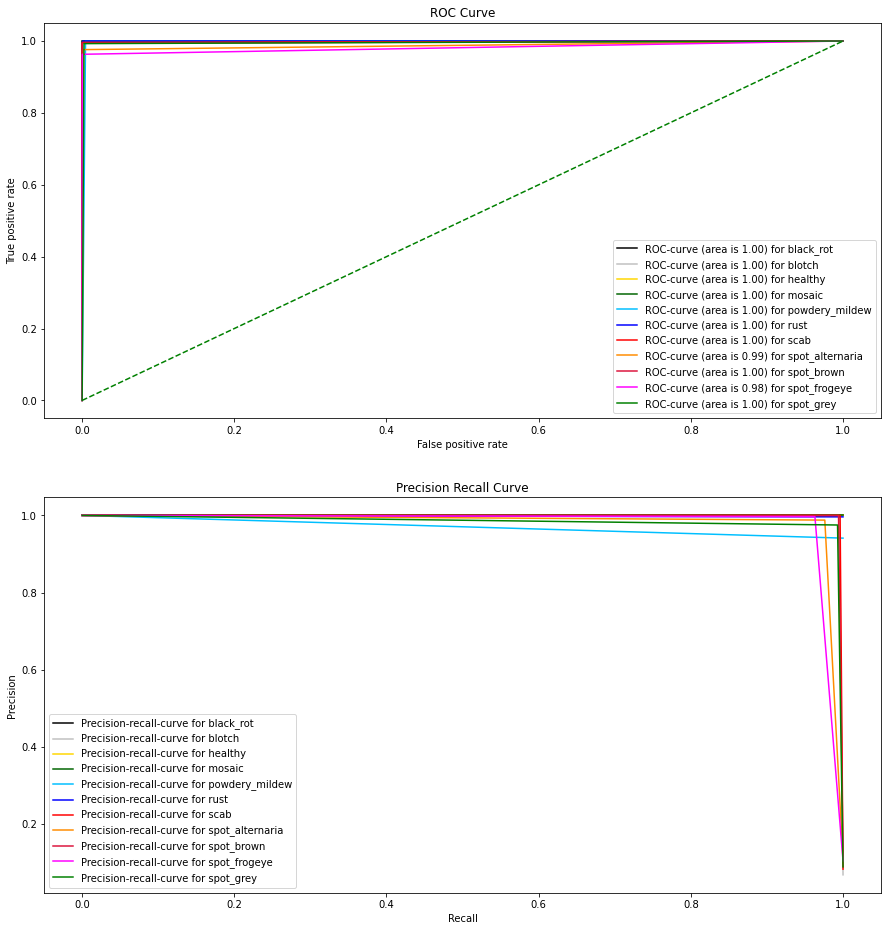

In [42]:
# Изображение графика
fig, axs = plt.subplots(2, 1)
fig.set_figwidth(15)
fig.set_figheight(16)
colors = ['black', 'silver', 'gold', 'darkgreen', 'deepskyblue', 'blue', 'red', 'darkorange', 'crimson', 'magenta', 'green']

# Вычисление и отображение метрик на графики
for class_ in classes:
    class_ = int(class_)
    class_name = disease_classes[class_]
    color = colors[class_]
    test = (test_grs == class_).numpy()
    predict = (test_predictions == class_).numpy()
    # ROC-кривая
    fpr, tpr, _ = roc_curve(test, predict)
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, label=f"ROC-curve (area is {roc_auc:.2f}) for {class_name}", color=color)
    # Precision-Recall-кривая
    pr, re, _ = precision_recall_curve(test, predict)
    axs[1].plot(re, pr, label=f"Precision-recall-curve for {class_name}", color=color)
    print(pr, re)

# Настройки первого графика
axs[0].plot([0, 1], [0, 1], color="green", linestyle='--')
axs[0].set_xlabel("False positive rate")
axs[0].set_ylabel("True positive rate")
axs[0].legend()
axs[0].set_title("ROC Curve")

# Настройки второго графика
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].set_title("Precision Recall Curve")

In [44]:
conf_matrix = metrics.confusion_matrix(test_grs, test_predictions)
conf_matrix

array([[254,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 212,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0, 322,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 306,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 208,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 268,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1, 258,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0, 326,   0,   1,   6],
       [  0,   0,   0,   0,   0,   0,   0,   1, 336,   0,   1],
       [  0,   0,   0,   0,  11,   0,   0,   1,   0, 313,   0],
       [  0,   0,   0,   0,   1,   0,   0,   1,   0,   0, 275]],
      dtype=int64)

In [58]:
f1_list = []

for i in range(conf_matrix.shape[0]):
    row = np.delete(conf_matrix[i], i)
    col = np.delete(conf_matrix[:, i], i)
    tp = conf_matrix[i, i]
    fn = row.sum()
    fp = col.sum()
    # Precision = true positives / (true positives + false positives)
    # Recall = true positives / (true positives + false negatives)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    f1_list.append(f1)
    
print(f1_list)

[1.0, 0.9976470588235293, 1.0, 1.0, 0.9696969696969697, 0.9981378026070763, 0.9980657640232108, 0.9819277108433735, 0.9970326409495549, 0.9796557120500783, 0.9838998211091234]


<BarContainer object of 11 artists>

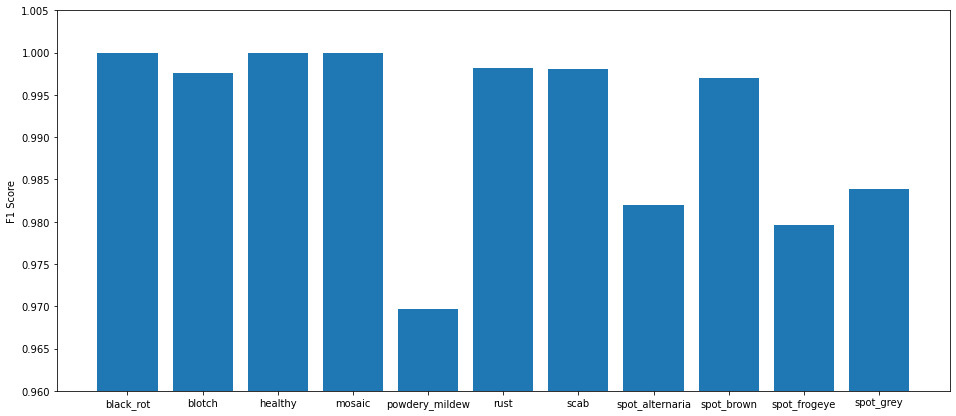

In [92]:
plt.figure(figsize=(16, 7))
plt.ylim([0.96, 1.005])
plt.ylabel("F1 Score")
plt.bar(disease_classes, f1_list)

### Приложение А

In [ ]:
import os
import shutil
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

dataset_path = 'AppleDiseases1'
disease_classes = os.listdir(dataset_path)
disease_classes
preprocess_path = 'AppleDiseases2'
shutil.copytree(dataset_path, preprocess_path, dirs_exist_ok=True)
ROTATE_45 = 7
ROTATE_135 = 8

def imageAugmentation(path, fileformat, transforms):
    fileformat = "." + fileformat
    path = os.path.join(preprocess_path, path)
    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        with Image.open(filepath) as img:
            img.load()
        for idx, transform in enumerate(transforms):
            newfilepath = filepath.replace(fileformat, f"_{idx}" + fileformat)
            if not os.path.isfile(newfilepath):
                if transform == ROTATE_45:
                    converted_img = img.rotate(45, expand=False)
                elif transform == ROTATE_135:
                    converted_img = img.rotate(135, expand=False)
                else:
                    converted_img = img.transpose(transform)
                converted_img.save(newfilepath)
                
imageAugmentation('black_rot', 'JPG', [Image.FLIP_LEFT_RIGHT])
imageAugmentation('blotch', 'jpeg', [Image.FLIP_TOP_BOTTOM, Image.FLIP_LEFT_RIGHT, Image.ROTATE_90,
    Image.ROTATE_270, Image.TRANSPOSE, Image.TRANSVERSE, Image.ROTATE_180, ROTATE_45, ROTATE_135])
imageAugmentation('mosaic', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('rust', 'JPG', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE, Image.TRANSPOSE])
imageAugmentation('scab', 'JPG', [Image.FLIP_LEFT_RIGHT])
imageAugmentation('spot_alternaria', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('spot_brown', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])
imageAugmentation('spot_grey', 'jpg', [Image.ROTATE_90, Image.ROTATE_270, Image.TRANSVERSE])

dataset_path = preprocess_path
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
apple_diseases_dataset = torchvision.datasets.ImageFolder(dataset_path, transform=img_transform)
train_size = int(len(apple_diseases_dataset)*0.8)
test_size  = len(apple_diseases_dataset) - train_size
train_diseases, test_diseases = torch.utils.data.random_split(apple_diseases_dataset, [train_size, test_size])
train_diseases_dataloader = DataLoader(train_diseases, batch_size=16, shuffle=True, pin_memory=True)
test_diseases_dataloader = DataLoader(test_diseases, batch_size=16, pin_memory=True)

### Приложение Б

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import models

def calculate_accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    return (torch.sum(y_pred == y_true) / len(y_true)).item()

def train(train_loader, model, loss, optimizer, device):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        curr_loss = loss(y_pred, y_batch)
        curr_loss.backward()
        optimizer.step()
        train_loss += curr_loss
        train_acc += calculate_accuracy(y_pred, y_batch)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    return train_loss, train_acc

def test(test_loader, model, loss, device):
    test_loss = 0.0
    test_acc = 0.0
    with torch.inference_mode():
        model.eval()
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            curr_loss = loss(y_pred, y_batch)
            test_loss += curr_loss
            test_acc += calculate_accuracy(y_pred, y_batch)
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    return test_loss, test_acc

def fit_model(train_loader, test_loader, model, loss, optimizer, epochs, device='cpu'):
    train_loss_history = []
    test_loss_history = []
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train(train_loader, model, loss, optimizer, device)
        test_loss, test_acc = test(test_loader, model, loss, device)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | ", end='')
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")
    return train_loss_history, test_loss_history

class AppleDiseaseModel(nn.Module):
    def __init__(self, out_features):
        super(AppleDiseaseModel, self).__init__()
        self.model = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1
        )
        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, out_features),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, data):
        return self.model(data)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
model = AppleDiseaseModel(len(disease_classes))
model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 15
h_train, h_loss = fit_model(train_diseases_dataloader, test_diseases_dataloader, model, loss, optimizer, n_epochs, device)